In [327]:
import pandas as pd
import numpy as np
import graphviz
from scipy.stats import rankdata
import pickle
import scipy.stats as stats
from gplearn import genetic
from gplearn.functions import make_function
from gplearn.genetic import SymbolicTransformer, SymbolicRegressor, SymbolicClassifier

from gplearn.fitness import make_fitness

from sklearn.utils import check_random_state
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from scipy import stats
import seaborn as sns

In [6]:
start_date = '20100101'
end_date = '20200601'
file_dir = r"./RB_data.csv"

data = pd.read_csv(file_dir)
data = data.set_index(data.columns[0])
data.index = pd.to_datetime(data.index, format="%Y-%m-%d")
data.head()

,收盘价,开盘价,最高价,最低价,持仓量,成交量
Unnamed: 0,,,,,,
2010-01-04,4579.0,4523.0,4610.0,4523.0,965458.0,1809996.0
2010-01-05,4589.0,4592.0,4606.0,4572.0,987708.0,1320756.0
2010-01-06,4622.0,4587.0,4635.0,4581.0,1027884.0,1481228.0
2010-01-07,4489.0,4641.0,4650.0,4389.0,932514.0,2196160.0
2010-01-08,4462.0,4505.0,4510.0,4412.0,894544.0,1520076.0


In [13]:
def _delta(data):
    value = np.diff(data.flatten())
    value = np.append(0, value)

    return value
def _delay(data):
    period=1
    value = pd.Series(data.flatten()).shift(1)
    value = np.nan_to_num(value)
    
    return value
            
def _corr(data1,data2,n):
    
    with np.errstate(divide='ignore', invalid='ignore'):
        try:
            if n[0] == n[1] and n[1] ==n[2]:
                window  = n[0]

                x1 = pd.Series(data1.flatten())
                x2 = pd.Series(data2.flatten())

                df = pd.concat([x1,x2],axis=1)
                temp = pd.Series()
                for i in range(len(df)):
                    if i<=window-2:
                        temp[str(i)] = np.nan
                    else:
                        df2 = df.iloc[i-window+1:i,:]
                        temp[str(i)] = df2.corr('spearman').iloc[1,0]
                return np.nan_to_num(temp)
            else:
                return np.zeros(data1.shape[0])
            
        except:
            return np.zeros(data1.shape[0])



def _ts_sum(data,n):

    with np.errstate(divide='ignore', invalid='ignore'):

        try:
            if n[0] == n[1] and n[1] ==n[2]:
                window  = n[0]
    
                value = np.array(pd.Series(data.flatten()).rolling(window).sum().tolist())
                value = np.nan_to_num(value)
    
                return value
            else:
                return np.zeros(data.shape[0])

        except:
            return np.zeros(data.shape[0])
        

def _sma(data,n):
    with np.errstate(divide='ignore', invalid='ignore'):

        try:    
            if n[0] == n[1] and n[1] ==n[2]:
                window  = n[0]
                
                value = np.array(pd.Series(data.flatten()).rolling(window).mean().tolist())
                value = np.nan_to_num(value)
    
                return value
            else:
                return np.zeros(data.shape[0])
              
        except:
            return np.zeros(data.shape[0])

def _stddev(data,n):   
    with np.errstate(divide='ignore', invalid='ignore'):

        try:    
            if n[0] == n[1] and n[1] ==n[2]:
                window  = int(np.mean(n))
                
                value = np.array(pd.Series(data.flatten()).rolling(window).std().tolist())
                value = np.nan_to_num(value)
    
                return value
            else:
                return np.zeros(data.shape[0])
                
        except:
            return np.zeros(data.shape[0])

def _ts_rank(data,n):
    
    with np.errstate(divide='ignore', invalid='ignore'):

        try:
            if n[0] == n[1] and n[1] ==n[2]:        
                value = np.array(pd.Series(data.flatten()).rolling(window).apply(_rolling_rank).tolist())
                value = np.nan_to_num(value)

                return value
            else:
                return np.zeros(data.shape[0])    
        except:
            return np.zeros(data.shape[0])

def _ts_argmin(data,n):

    try:
        if n[0] == n[1] and n[1] ==n[2]:
            window=n[0]
            value = pd.Series(data.flatten()).rolling(window).apply(np.argmin) + 1 
            value = np.nan_to_num(value)
            return value
        else:
            return np.zeros(data.shape[0])  
    except:
        return np.zeros(data.shape[0])


def _ts_argmax(data,n):
    with np.errstate(divide='ignore', invalid='ignore'):
        try:
            if n[0] == n[1] and n[1] ==n[2]:
                window=n[0]
                value = pd.Series(data.flatten()).rolling(window).apply(np.argmax) + 1 
                value = np.nan_to_num(value)
                return value
            else:
                return np.zeros(data.shape[0])
        except:
            return np.zeros(data.shape[0])
        
def _ts_min(data,n):
    with np.errstate(divide='ignore', invalid='ignore'):
        
        try:
            if n[0] == n[1] and n[1] ==n[2]:
                window  = n[0]
                #window  = int(np.mean(n))
                value = np.array(pd.Series(data.flatten()).rolling(window).min().tolist())
                value = np.nan_to_num(value)
    
                return value
            else:
                return np.zeros(data.shape[0])
                
        except:
            return np.zeros(data.shape[0])  
        
def _ts_max(data,n):
    with np.errstate(divide='ignore', invalid='ignore'):
        
        try:
            if n[0] == n[1] and n[1] ==n[2]:
                window  = n[0]
    
                value = np.array(pd.Series(data.flatten()).rolling(window).max().tolist())
                value = np.nan_to_num(value)
    
                return value
            else:
                return np.zeros(data.shape[0])
         
                
        except:
            return np.zeros(data.shape[0])  
        
def _ts_argmaxmin(data,n):
    return _ts_argmax(data,n) - _ts_argmin(data,n)

def _rolling_rank(data):
    value = rankdata(data)[-1]
    
    return value
def _rolling_prod(data):
    
    return np.prod(data)

def _cube(data):
    return np.square(data)*data

def _square(data):
    return np.square(data)
def _ts_rank(data,n):
    
    with np.errstate(divide='ignore', invalid='ignore'):

        try:
            if n[0] == n[1] and n[1] ==n[2]:        
                value = np.array(pd.Series(data.flatten()).rolling(window).apply(_rolling_rank).tolist())
                value = np.nan_to_num(value)

                return value
            else:
                return np.zeros(data.shape[0])    
        except:
            return np.zeros(data.shape[0])




In [18]:
stddev = make_function(function=_stddev, name='stddev', arity=2)
ts_sum = make_function(function=_ts_sum, name='ts_sum', arity=2)
ts_sum = make_function(function=_ts_sum, name='ts_sum', arity=2)
stddev = make_function(function=_stddev, name='stddev', arity=2)
corr = make_function(function=_corr, name='corr', arity=3)#     
#ts_min = make_function(function=_ts_min, name='ts_min', arity=2)
ts_rank = make_function(function=_ts_rank, name='ts_rank', arity=2)
delta = make_function(function=_delta, name='delta', arity=1)
delay = make_function(function=_delay, name='delay', arity=1)
sma = make_function(function=_sma, name='sma', arity=2)
cube = make_function(function=_cube, name='cube', arity=1)
square = make_function(function=_square, name='square', arity=1)
ts_argmaxmin = make_function(function=_ts_argmaxmin, name='ts_argmaxmin', arity=2)

ts_argmax = make_function(function=_ts_argmax, name='ts_argmax', arity=2)
ts_argmin = make_function(function=_ts_argmin, name='ts_argmin', arity=2)
ts_min = make_function(function=_ts_min, name='ts_min', arity=2)
   
ts_max = make_function(function=_ts_max, name='ts_max', arity=2)
#定义一个函数集
user_function = [square,cube,delta, delay, ts_argmax ,sma,stddev, ts_argmin, ts_max,ts_min,ts_sum,ts_rank,ts_argmaxmin,corr 
                 ]
init_function = ['add', 'sub', 'mul', 'div','sqrt', 'log','inv','sin','max','min']
function_set = init_function + user_function

# 定义适应度

In [328]:

def _my_metric(y, y_pred, w):
    value = -np.sum((y - y_pred)**2)
    print('y: '+str(y))
    print('y_pred: '+str(y_pred))
    return value
my_metric = make_fitness(function=_my_metric, greater_is_better=True)

y: [1 1]
y_pred: [2 2]


In [243]:
features.head()

,收盘价,开盘价,最高价,最低价,持仓量,成交量
Unnamed: 0,,,,,,
2010-01-05,4579.0,4523.0,4610.0,4523.0,965458.0,1809996.0
2010-01-06,4589.0,4592.0,4606.0,4572.0,987708.0,1320756.0
2010-01-07,4622.0,4587.0,4635.0,4581.0,1027884.0,1481228.0
2010-01-08,4489.0,4641.0,4650.0,4389.0,932514.0,2196160.0
2010-01-11,4462.0,4505.0,4510.0,4412.0,894544.0,1520076.0


In [229]:
features = (data.shift()).iloc[1:, :].ffill()
TARGET = (data.diff()/data.shift()).iloc[1:, 0]
TARGET.name = 'TARGET'
TARGET.head()


Unnamed: 0
2010-01-05    0.002184
2010-01-06    0.007191
2010-01-07   -0.028775
2010-01-08   -0.006015
2010-01-11    0.012102
Name: TARGET, dtype: float64

In [230]:
x_train, x_test, y_train, y_test = train_test_split(features, TARGET,
                                                        test_size=0.3, shuffle=True)
train_idx = x_train.index
test_idx = x_test.index

In [326]:
?SymbolicTransformer

In [329]:
est_gp = SymbolicTransformer(generations=3,   # 公式进化的世代数量
                             population_size=1000, # 每一代生成因子数量
                             hall_of_fame=100,  # 备选因子的数量
                             n_components=10, # 最终筛选出的最优因子的数量
                             function_set=function_set, # 函数集
                             parsimony_coefficient=0.0005,  # 节俭系数
                             max_samples=0.9,  # 最大采样比例
                             metric=my_metric, # 适应度指标，可以用make_fitness自定义
                             verbose=1,)
# x_train = np.nan_to_num(x_train)
# y_train = np.nan_to_num(y_train)

est_gp.fit(x_train, y_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0

  0.00383959]
y_pred: [1. 1. 1. ... 1. 1. 1.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [1. 1. 1. ... 1. 1. 1.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [ 1.000000e+00 -1.292667e+06  5.285300e+04 ... -1.588575e+06  1.249331e+06
 -2.681425e+06]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [ 1.000000e+00 -1.292667e+06  5.285300e+04 ... -1.588575e+06  1.249331e+06
 -2.681425e+06]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.011

  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ..

y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [24981588.79492633  6491019.89522585  2050900.47483317 ...
 20173125.38352752  8438639.39562344  3107438.14315426]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [24981588.79492633  6491019.89522585  2050900.47483317 ...
 20173125.38352752  8438639.39562344  3107438.14315426]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [ 0.00000000e+00  7.45530835e+09 -1.20555016e+10 ...  2.27963678e+10
 -2.95377904e+10  3.41831987e+10]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [ 0.00000000e+00  7.45530835e+09 -1.20555016e+10 ...  2.27963678e+10
 -2.95377904e+10  3.41831987e+10]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: 

y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0.         8.50929764 7.81208728 ... 7.88222902 8.38881634 7.97052163]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0.         8.50929764 7.81208728 ... 7.88222902 8.38881634 7.97052163]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0.

  0.00383959]
y_pred: [ 0.00000000e+00  7.73593838e-07 -1.89207599e-05 ...  6.29494591e-07
 -8.00429030e-07  3.72935893e-07]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [-0. -0. -0. ... -0. -0. -0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [-0. -0. -0. ... -0. -0. -0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [-0.5962286 -0.5962286 -0.5962286 ... -0.5962286 -0.5962286 -0.5962286]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [-0.5962286 -0.5962286 -0.5962286 ... -0.5962286 -0.5962286 -0.5962286]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y

y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred

y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [    0.         -2491.08766179  1437.06747941 ...  3160.20582742
 -3251.5156192    328.3058831 ]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [    0.         -2491.08766179  1437.06747941 ...  3160.20582742
 -3251.5156192    328.3058831 ]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125

y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621  

y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred

  0.00383959]
y_pred: [       0.         24608322.94032298  6102289.34427961 ...
  7021293.64084564 19338968.01894107  8377358.87420186]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.002437

y_pred: [0.00000000e+00 4.29574720e+10 4.69153189e+10 ... 2.65764874e+10
 1.07684182e+11 3.70095627e+10]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 

y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred

  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ..

  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [70.68370556 50.02910934 37.65969311 ... 66.91445185 53.80660466
 41.98562506]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [70.68370556 50.02910934 37.65969311 ... 66.91445185 53.80660466
 41.98562506]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0

y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [1. 1. 1. ... 1. 1. 1.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [1. 1. 1. ... 1. 1. 1.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [        0.         -18697309.47738611  -4253127.27403128 ...
  12855733.23171506 -11666501.46764995  -5274459.45986815]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [        0.         -18697309.47738611  -4253127.27403128 ...
  12855733.23171506 -11666501.46764995  -5274459.45986815]
y: [ 0.0

y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred

  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ..

y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [-0.33794598 -0.33794598 -0.33794598 ... -0.33794598 -0.33794598
 -0.33794598]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [-0.33794598 -0.33794598 -0.33794598 ... -0.33794598 -0.3

  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [1. 1. 1. ... 1. 1. 1.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [1. 1. 1. ... 1. 1. 1.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [5.00380580e+09 5.68501135e+09 3.18730856e+09 ... 1.24934587e+10
 4.60677831e+09 7.34935114e+09]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [5.00380580e+09 5.68501135e+09 3.18730856e+09 ... 1.24934587e+10
 4.60677831e+09 7.34935114e+09]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [1. 1. 1. ... 1. 1. 1.]
y: [ 0.008

y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [1.46512633e-06 2.30356574e-07 2.26370333e-07 ... 2.39939458e-07
 8.04348630e-07 7.75849602e-08]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [1.46512633e-06 2.30356574e-07 2.26370333e-07 ... 2.39939458e-07
 8.04348630e-07 7.75849602e-08]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621  

y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [  682535.  4341096.  4417540. ...  4167718.  1243242. 12889096.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [  682535.  4341096.  4417540. ...  4167718.  1243242. 12889096.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0.00020063 0.00038648 0.00069646 ... 0.00022584 0.00034327 0.00057763]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0.00020063 0.00038648 0.00069646 ... 0.00022584 0.00034327 0.00057763]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 

  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0.00000000e+00 3.45410590e-08 9.60897497e-08 ... 2.21678676e-08
 1.37888581e-08 5.49266890e-08]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0.00000000e+00 3.45410590e-08 9.60897497e-08 ... 2.21678676e-08
 1.37888581e-08 5.49266890e-08]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [1.38419641e-08 5.51548705e-08 1.71778121e-07 ... 1.72343638e-08
 4.12223364e-08 1.11191723e-07]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [1.38419641e-08 5.51548705e-08 1.71778121e-07 ... 1.72343638e-08
 4.12223364e-08 1.11191723e-07]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0

y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621  

y_pred: [0.00011765 0.00023485 0.00041446 ... 0.00013128 0.00020303 0.00033345]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0

y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [9.32246855e-05 9.32246855e-05 9.32246855e-05 ... 9.32246855e-05
 9.32246855e-05 9.32246855e-05]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [9.32246855e-05 9.32246855e-05 9.322468

  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ..

  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [4996.18623179 2502.91178137 1418.25248502 ... 4477.54386586 2895.15070472
 1762.79271134]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [4996.18623179 2502.91178137 1418.25248502 ... 4477.54386586 2895.15070472
 1762.79271134]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.011

y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621  

y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621  

  0.00383959]
y_pred: [4984.35004435 2587.45457931 1435.82505066 ... 4427.88757738 2913.18170017
 1731.20683511]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [4984.35004435 2587.45457931 1435.82505066 ... 4427.88757738 2913.18170017
 1731.20683511]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.011

  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0.69331134 0.69331134 0.69331134 ... 0.69331134 0.69331134 0.69331134]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0.69331134 0.69331134 0.69331134 ... 0.69331134 0.69331134 0.69331134]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.0

y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [      0.  682535. 4341096. ... 1560496. 4167718. 1243242.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [      0.  682535. 4341096. ... 1560496. 4167718. 1243242.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [       0.  1292668.   -52852. ...  1588576. -1249330.  2681426.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [       0.  1292668.   -52852. ...  1588576. -1249330.  2681426.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [   0.          512.68646781  -17.52080938 ...  566.41421921 -423.91596733
  805.53803133]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00

y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [       0.        0.  1292668. ...  -977082.  1588576. -1249330.]
y: [ 0.0086865

  0.00383959]
y_pred: [9.32246855e-05 9.32246855e-05 9.32246855e-05 ... 9.32246855e-05
 9.32246855e-05 9.32246855e-05]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [9.32246855e-05 9.32246855e-05 9.32246855e-05 ... 9.32246855e-05
 9.32246855e-05 9.32246855e-05]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [2.14659516e-12 5.30641510e-14 5.12435276e-14 ... 5.75709437e-14
 6.46976719e-13 6.01942605e-15]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [2.14659516e-12 5.30641510e-14 5.12435276e-14 ... 5.75709437e-14
 6.46976719e-13 6.01942605e-15]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [7.99936822e-12 5.73320943e-11 3.30694447e-10 ... 1.09345266e-11
 4.03827825e-11 1.82556063e-10]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [7.99936822e-12 5.73320943e-11 3.30694447e-

y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [9.32246855e-05 9.32246855e-05 9.32246855e-05 ... 9.32246855e-05
 9.32246855e-05 9.32246855e-05]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [5000.1316276  2593.38740724 1446.07571395 ... 4505.39983256 2914.74961282
 1762.79271134]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [5000.1316276  2593.38740724 1446.07571395 ... 4505.39983256 2914.74961282
 1762.79271134]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [4996.18623179 2502.91178137 1418.25248502 ... 4477.54386586 2895.15070472
 1762.79271134]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [4996.18623179 2502.91178137 1418.25248502 ... 4477.54386586 2895.15070472
 1762.79271134]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred:

y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0.00020159 0.00040481 0.00070546 ... 0.0002274  0.0003455  0.00058142]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0.00020159 0.00040481 0.00070546 ... 0.0002274  0.0003455  0.00058142]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [4.00610902e-08 1.59627942e-07 4.97156239e-07 ... 4.98792944e-08
 1.19304726e-07 3.21808498e-07]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [4.00610902e-08 1.59627942e-07 4.97156239e-07 ... 4.98792944e-08
 1.19304726e-07 3.21808498e-07]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00

y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0.00019999 0.0003856  0.00069153 ... 0.00022196 0.00034308 0.00056728]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0.00019999 0.0003856  0.00069153 ... 0.00022196 0.00034308 0.00056728]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0.

y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0.00020063 0.00038648 0.00069646 ... 0.00022584 0.00034327 0.00057763]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0.00020063 0.00038648 0.00069646 ... 0.00022584 0.00034327 0.00057763]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0.00020063 0.00038648 0.00069646 ... 0.00022584 0.00034327 0.00057763]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0.00020063 0.00038648 0.00069646 ... 0.00022584 0.00034327 0.00057763]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [1.46512633e-06 2.30356574e-07 2.2

y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [  682535.  4341096.  4417540. ...  4167718.  1243242. 12889096.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [  682535.  4341096.  4417540. ...  4167718.  1243242. 12889096.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [-2.33202766 -2.33202766 -2.33202766 ... -2.33202766 -2.33202766
 -2.33202766]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [-2.33202766 -2.33202766 -2.33202766 ... -2.33202766 -2.33202766
 -2.33202766]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0.00019999 0.0003856  0.0006915

  0.00383959]
y_pred: [0.00020063 0.00038648 0.00069646 ... 0.00022584 0.00034327 0.00057763]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0.00020063 0.00038648 0.00069646 ... 0.00022584 0.00034327 0.00057763]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0.00020063 0.00038648 0.00069646 ... 0.00022584 0.00034327 0.00057763]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0.00020063 0.00038648 0.00069646 ..

  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ..

y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0.00019999 0.0003856  0.00069153 ... 0.00022196 0.00034308 0.00056728]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0.00019999 0.0003856  0.00069153 ... 0.00022196 0.00034308 0.00056728]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [-2.33202766 -2.33202766 -2.33202766 ... -2.33202766 -2.33202766
 -2.33202766]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [-2.33202766 -2.33202766 -2.33202766 ... -2.33202766 -2.33202766
 -2.33202766]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [9.91380934e-07 4.34525294e-07 4.44738960e-07 ... 3.51992949e-07
 6.28284356e-07 2.34024220e-07]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [9.91380934e-07 4.34525294e-07 4.44738960e-07 ... 3.51992949e

y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [0. 0. 0. ... 0. 0. 0.]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [2.14659516e-12 5.30641510e-14 5.12435276e-14 ... 5.75709437e-14
 6.46976719e-13 6.01942605e-15]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [2.14659516e-12 5.30641510e-14 5.12435276e-14 ... 5.75709437e-14
 6.46976719e-13 6.01942605e-15]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [1.46512633e-06 2.30356574e-07 2.26370333e-07 ... 2.39939458e-07
 8.04348630e-07 7.75849602e-08]
y: [ 0.0086865   0.01125926  0.01652039 ... -0.0232621   0.00243704
  0.00383959]
y_pred: [1.46512633e-06 2.30356574e-07 2.26370333e-07 ... 2.39939458e-07
 8.04348630e-07 7.75849602e-08]
y: [ 0.0086865   0.01125

SymbolicTransformer(const_range=(-1.0, 1.0), feature_names=None,
                    function_set=['add', 'sub', 'mul', 'div', 'sqrt', 'log',
                                  'inv', 'sin', 'max', 'min',
                                  <gplearn.functions._Function object at 0x000001C...
                    init_method='half and half', low_memory=False,
                    max_samples=0.9,
                    metric=<gplearn.fitness._Fitness object at 0x000001C04C69F6D8>,
                    n_components=10, n_jobs=1, p_crossover=0.9,
                    p_hoist_mutation=0.01, p_point_mutation=0.01,
                    p_point_replace=0.05, p_subtree_mutation=0.01,
                    parsimony_coefficient=0.0005, population_size=1000,
                    random_state=None, stopping_criteria=1.0,
                    tournament_size=20, verbose=1, warm_start=False)

In [321]:
best_programs = est_gp._best_programs
best_programs_dict = {}

for p in best_programs:
    factor_name = 'alpha_' + str(best_programs.index(p) + 1)
    best_programs_dict[factor_name] = {'fitness':p.fitness_, 'expression':str(p), 'depth':p.depth_, 'length':p.length_}
     
best_programs_dict = pd.DataFrame(best_programs_dict).T
best_programs_dict = best_programs_dict.sort_values(by='fitness')
best_programs_dict 

,fitness,expression,depth,length
alpha_9,-0.402008,delta(inv(X0)),2,3
alpha_10,-0.402008,delta(inv(X0)),2,3
alpha_8,-0.402006,delta(inv(X2)),2,3
alpha_2,-0.401998,delta(inv(X3)),2,3
alpha_3,-0.401998,delta(inv(X3)),2,3
alpha_4,-0.401998,delta(inv(X3)),2,3
alpha_5,-0.401998,delta(inv(X3)),2,3
alpha_6,-0.401998,delta(inv(X3)),2,3
alpha_7,-0.401998,delta(inv(X3)),2,3
alpha_1,-0.401997,delta(inv(X1)),2,3


delay(inv(X5))
fitness: -19.10587090260446, depth: 2, length: 3


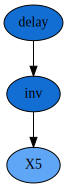

In [299]:
def alpha_factor_graph(num):
    # 打印指定num的表达式图

    factor = best_programs[num-1]
    print(factor)
    print('fitness: {0}, depth: {1}, length: {2}'.format(factor.fitness_, factor.depth_, factor.length_))

    dot_data = factor.export_graphviz()
    graph = graphviz.Source(dot_data)
    graph.render('images/alpha_factor_graph', format='png', cleanup=True)
    
    return graph

graph1 = alpha_factor_graph(1)
graph1

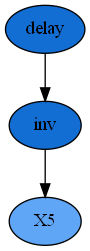

In [300]:
from IPython.display import Image
import pydotplus
graph = est_gp._best_programs[0].export_graphviz()
graph = pydotplus.graphviz.graph_from_dot_data(graph)
Image(graph.create_png())

In [302]:
gp_train_feature = est_gp.transform(x_train)
gp_test_feature = est_gp.transform(x_test)

new_feature_name = [str(x) for x in est_gp._best_programs]
train_new_feature = pd.DataFrame(gp_train_feature, columns=new_feature_name, index=train_idx)
test_new_feature = pd.DataFrame(gp_test_feature, columns=new_feature_name, index=test_idx)

In [303]:
train_new_feature = pd.concat([x_train, train_new_feature], axis=1)
test_new_feature = pd.concat([x_test, test_new_feature], axis=1)

new_x_data = pd.concat([train_new_feature, test_new_feature], axis=0)
new_data = pd.concat([new_x_data, TARGET], axis=1)

# plot_dist(new_data_1, new_feature_name_W)
new_corr

,收盘价,开盘价,最高价,最低价,持仓量,成交量,"min(stddev(sma(X5, X0), stddev(0.806, X1)), delta(cube(cube(X5))))","div(delta(max(X5, X1)), sin(div(X5, X4)))",cube(cube(cube(X1))),"max(cube(cube(X5)), square(max(X5, X1)))","cube(delta(max(X5, X1)))","delta(square(sub(cube(delta(max(X5, X1))), ts_argmax(X4, X1))))","square(delay(add(sma(sin(X0), stddev(X4, -0.914)), delta(max(X1, X3)))))","delta(max(inv(min(sma(X1, X3), delay(X1))), add(ts_sum(stddev(X0, sin(X2)), square(X3)), sin(log(X2)))))","div(max(X0, 0.731), sin(div(X5, X4)))",cube(cube(delta(sqrt(square(cube(X2)))))),TARGET
收盘价,1.000000,0.999159,0.999614,0.999601,-0.481028,-0.502928,-0.207427,-0.261906,0.999159,-0.502928,-0.334239,-0.085792,0.000226,-0.342317,0.779043,0.653684,0.020183
开盘价,0.999159,1.000000,0.999601,0.999578,-0.481838,-0.503902,-0.207746,-0.262107,1.000000,-0.503902,-0.334630,-0.084614,0.000295,-0.343103,0.778484,0.653529,0.020644
最高价,0.999614,0.999601,1.000000,0.999453,-0.476529,-0.495937,-0.204477,-0.258129,0.999601,-0.495937,-0.329409,-0.084483,0.000520,-0.343007,0.777280,0.654140,0.020950
最低价,0.999601,0.999578,0.999453,1.000000,-0.485793,-0.510705,-0.211182,-0.266166,0.999578,-0.510705,-0.339721,-0.086481,-0.000566,-0.342783,0.780103,0.653588,0.020251
持仓量,-0.481028,-0.481838,-0.476529,-0.485793,1.000000,0.815349,0.345165,0.504126,-0.481838,0.815349,0.540726,0.068233,0.013681,0.096140,-0.533627,-0.280170,0.015642
成交量,-0.502928,-0.503902,-0.495937,-0.510705,0.815349,1.000000,0.436382,0.561335,-0.503902,1.000000,0.677133,0.116512,0.029508,0.092445,-0.560167,-0.286098,0.022031
"min(stddev(sma(X5, X0), stddev(0.806, X1)), delta(cube(cube(X5))))",-0.207427,-0.207746,-0.204477,-0.211182,0.345165,0.436382,1.000000,0.797462,-0.207746,0.436382,0.905136,0.037879,-0.031078,0.120173,-0.236301,-0.379308,0.025326
"div(delta(max(X5, X1)), sin(div(X5, X4)))",-0.261906,-0.262107,-0.258129,-0.266166,0.504126,0.561335,0.797462,1.000000,-0.262107,0.561335,0.851650,0.030933,-0.021941,0.122675,-0.228398,-0.351303,0.042698
cube(cube(cube(X1))),0.999159,1.000000,0.999601,0.999578,-0.481838,-0.503902,-0.207746,-0.262107,1.000000,-0.503902,-0.334630,-0.084614,0.000295,-0.343103,0.778484,0.653529,0.020644
"max(cube(cube(X5)), square(max(X5, X1)))",-0.502928,-0.503902,-0.495937,-0.510705,0.815349,1.000000,0.436382,0.561335,-0.503902,1.000000,0.677133,0.116512,0.029508,0.092445,-0.560167,-0.286098,0.022031


D:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 25345 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 20179 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 37327 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 25910 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 30424 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 20215 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda\lib\site-package

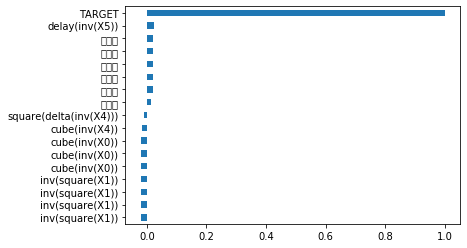

In [304]:
new_corr = new_data.corr('spearman')
# sns.heatmap(corr)
# corr
new_corr['TARGET'].sort_values().plot.barh()

In [305]:
new_features_corr = new_data[new_feature_name].corr('spearman')

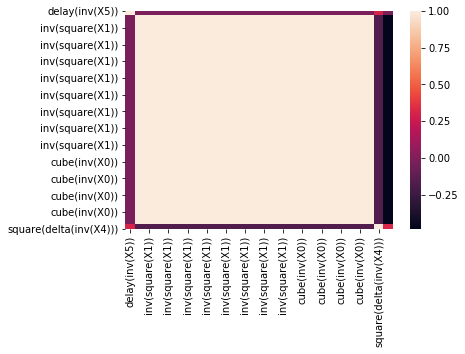

In [306]:
sns.heatmap(new_features_corr)

In [307]:
def Preds(x, y, x_test, y_test, alpha, n_splits=4, random_state=23, verbose=0):
    feature_importance = pd.DataFrame(columns=['feature', 'importance', 'fold'])

    folds = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    oof_preds, sub_preds = np.zeros(x.shape[0]), np.zeros(x_test.shape[0])

    oof_train = np.zeros(x.shape[0])

    if verbose > 0:
        print(x.shape, x_test.shape)

    train_scores = []
    valid_scores = []
    test_scores = []


    for n_fold, (trn_idx, val_idx) in enumerate(folds.split(x, y)):
        trn_x, trn_y = x.iloc[trn_idx, :], y.iloc[trn_idx]
        val_x, val_y = x.iloc[val_idx, :], y.iloc[val_idx]

        # print(type(trn_x.values), type(trn_y.values), type(val_x.values), type(val_y.values))
        #
        # print(trn_x.shape, trn_y.shape)
        # print(val_x.shape, val_y.values.ravel().shape)

        model = Ridge(alpha=alpha) 
        model.fit(trn_x.values, trn_y.values.ravel())

        trn_preds = model.predict(trn_x)
        val_preds = model.predict(val_x)
        test_preds = model.predict(x_test)

        oof_preds[val_idx] = val_preds
        sub_preds += test_preds/folds.n_splits

        train_score = mean_squared_error(trn_y, trn_preds)
        val_score = mean_squared_error(val_y, val_preds)
        test_score = mean_squared_error(y_test, test_preds)

        train_scores.append(train_score)
        valid_scores.append(val_score)
        test_scores.append(test_score)

        feature_importance = feature_importance.append(pd.DataFrame({
            'importance': model.coef_,
            'fold': [n_fold + 1] * x.shape[1],
            'feature': x.columns.tolist()
        }))

  
    feature_importance['importance'] = feature_importance['importance'].astype(float)

    fi = feature_importance.groupby(['feature']).agg(['mean'])['importance'].sort_values(by=['mean'], ascending=False)

    fold_names = list(range(folds.n_splits))
    fold_names.append('overall')

    valid_mse = mean_squared_error(y, oof_preds)

    valid_scores.append(valid_mse)
    train_scores.append(np.mean(train_scores))
    test_scores.append(np.mean(test_scores))

    # 构建记录分数的 Dataframe
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores,
                            'test': test_scores})

    oof_preds = pd.Series(oof_preds.flatten(), index=x.index).rename('TARGET')
    sub_preds = pd.Series(sub_preds.flatten(), index=x_test.index).rename('TARGET')

    return metrics, fi

In [308]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
for alpha in alphas:
    metrics, fi = Preds(x_train, y_train, x_test, y_test, alpha)
    print('\n{}'.format(alpha))
    print(metrics)

# 验证集上 0.01最优
metrics, fi = Preds(x_train, y_train, x_test, y_test, 0.01)

D:\anaconda\lib\site-packages\pandas\core\frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
D:\anaconda\lib\site-packages\pandas\core\frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
D:\anaconda\lib\site-packages\pandas\core\frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
D:\anacond


0.001
      fold     train     valid      test
0        0  0.000204  0.000208  0.000188
1        1  0.000213  0.000181  0.000188
2        2  0.000206  0.000203  0.000189
3        3  0.000196  0.000235  0.000186
4  overall  0.000205  0.000207  0.000188

0.005
      fold     train     valid      test
0        0  0.000204  0.000208  0.000188
1        1  0.000213  0.000181  0.000188
2        2  0.000206  0.000203  0.000189
3        3  0.000196  0.000235  0.000186
4  overall  0.000205  0.000207  0.000188

0.01
      fold     train     valid      test
0        0  0.000204  0.000208  0.000188
1        1  0.000213  0.000181  0.000188
2        2  0.000206  0.000203  0.000189
3        3  0.000196  0.000235  0.000186
4  overall  0.000205  0.000207  0.000188

0.05
      fold     train     valid      test
0        0  0.000204  0.000208  0.000188
1        1  0.000213  0.000181  0.000188
2        2  0.000206  0.000203  0.000189
3        3  0.000196  0.000235  0.000186
4  overall  0.000205  0.000207 

D:\anaconda\lib\site-packages\pandas\core\frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
D:\anaconda\lib\site-packages\pandas\core\frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
D:\anaconda\lib\site-packages\pandas\core\frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
D:\anacond

D:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 26368 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 20302 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 20215 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 39640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 25104 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 20132 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda\lib\site-package

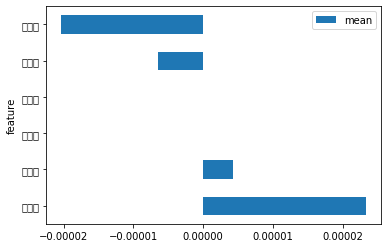

In [309]:
fi.plot.barh()

In [310]:
metrics

,fold,train,valid,test
0,0,0.000204,0.000208,0.000188
1,1,0.000213,0.000181,0.000188
2,2,0.000206,0.000203,0.000189
3,3,0.000196,0.000235,0.000186
4,overall,0.000205,0.000207,0.000188
